In [ ]:
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.ml.recommendation import ALS, ALSModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
appName = "add on"
master = "local"

In [ ]:
spark = SparkSession.builder \
    .appName(appName) \
    .master(master) \
    .config("spark.sql.broadcastTimeout", "36000") \
    .getOrCreate()

### load model

In [4]:
TEMP_PATH = "models/ALS_{}_{}_{}".format(20, 0.01, 1.0)

In [5]:
ALS_PATH = TEMP_PATH + "/als"
MODEL_PATH = TEMP_PATH + "/als_model"

In [6]:
als = ALS.load(ALS_PATH)

In [7]:
model = ALSModel.load(MODEL_PATH)

### process genres

In [8]:
sdf = spark.read.json("../goodreads_book_genres_initial.json")

In [9]:
sdf.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- children: long (nullable = true)
 |    |-- comics, graphic: long (nullable = true)
 |    |-- fantasy, paranormal: long (nullable = true)
 |    |-- fiction: long (nullable = true)
 |    |-- history, historical fiction, biography: long (nullable = true)
 |    |-- mystery, thriller, crime: long (nullable = true)
 |    |-- non-fiction: long (nullable = true)
 |    |-- poetry: long (nullable = true)
 |    |-- romance: long (nullable = true)
 |    |-- young-adult: long (nullable = true)



In [10]:
genres_rows = sdf.collect()

In [11]:
def find_genre(dic):
    for k, v in dic.items():
        if v is None:
            dic[k] = 0
    return max(dic, key = dic.get)

In [12]:
genres = {genres_rows[i][0]: find_genre(genres_rows[i][1].asDict()) for i in range(len(genres_rows))}

In [13]:
genres_df = pd.DataFrame(genres.items(), columns=["id", "genre"])

In [14]:
genres_df.head()

,id,genre
0,5333265,"history, historical fiction, biography"
1,1333909,fiction
2,7327624,"fantasy, paranormal"
3,6066819,fiction
4,287140,non-fiction


### get latent items

In [15]:
books_mapping = spark.read.parquet("data_local/raw/book_map.parquet")
books_mapping

DataFrame[num: int, id: string]

In [16]:
latent_items = model.itemFactors
latent_items

DataFrame[id: int, features: array<float>]

In [17]:
books_mapping.createOrReplaceTempView("books_mapping")
latent_items.createOrReplaceTempView("latent_items")

In [18]:
latent_items_with_id = spark.sql("SELECT a.id AS id, b.features FROM books_mapping a INNER JOIN latent_items b ON a.num = b.id")

In [19]:
latent_items_df = latent_items_with_id.toPandas()

In [20]:
latent_items_df.head()

,id,features
0,7015635,"[0.31482553482055664, -0.19428367912769318, 0...."
1,6719017,"[0.5416654944419861, 0.046169672161340714, 0.6..."
2,9895917,"[0.32508018612861633, 0.17077623307704926, 0.4..."
3,8694005,"[0.7871549129486084, 0.6814177632331848, 0.184..."
4,32542,"[-0.25290924310684204, -0.2115345001220703, 0...."


### join

In [21]:
df = pd.merge(latent_items_df, genres_df, on="id")
df.head()

,id,features,genre
0,7015635,"[0.31482553482055664, -0.19428367912769318, 0....",non-fiction
1,6719017,"[0.5416654944419861, 0.046169672161340714, 0.6...",non-fiction
2,9895917,"[0.32508018612861633, 0.17077623307704926, 0.4...",non-fiction
3,8694005,"[0.7871549129486084, 0.6814177632331848, 0.184...",fiction
4,32542,"[-0.25290924310684204, -0.2115345001220703, 0....","mystery, thriller, crime"


### train and save UMAP for latent factors of items

In [22]:
X = np.vstack(list(df.features))
X.shape

(2290756, 20)

In [23]:
X = StandardScaler().fit_transform(X)

In [24]:
samples = np.random.choice(X.shape[0], 200000, replace=False)

In [25]:
np.save("data_local/processed/samples.npy", samples)

In [26]:
from umap import UMAP

In [27]:
mapper = UMAP(verbose=True).fit(X[samples])
X_embedded = mapper.transform(X[samples])

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed May  6 18:58:36 2020 Finding Nearest Neighbors
Wed May  6 18:58:36 2020 Building RP forest with 27 trees
Wed May  6 18:58:49 2020 NN descent for 18 iterations
	 0  /  18
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	 7  /  18
	 8  /  18
	 9  /  18
	 10  /  18
	 11  /  18
	 12  /  18
	 13  /  18
	 14  /  18
	 15  /  18
We

In [28]:
np.save("data_local/processed/umap_embeddings.npy", X_embedded)

In [29]:
import pickle
pickle.dump(mapper, open("data_local/processed/umap_mapper.pkl", "wb"))

### plot UMAP results for latent factors of items

In [30]:
mapper = pickle.load(open("data_local/processed/umap_mapper.pkl", "rb"))
X_embedded = np.load("data_local/processed/umap_embeddings.npy")
samples = np.load("data_local/processed/samples.npy")

In [31]:
import umap.plot

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


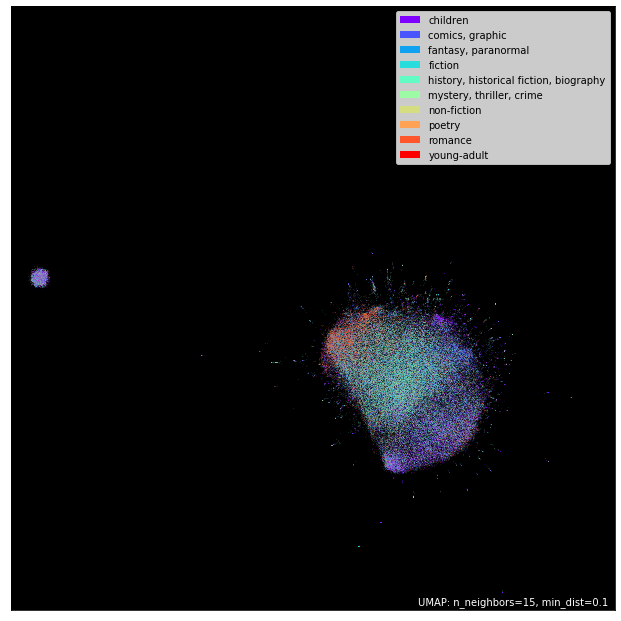

In [52]:
umap.plot.points(mapper, labels=df.genre[samples], theme='fire')
plt.savefig("figures/items.png")

In [33]:
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

target_names = df.genre[samples].unique()
plt.figure(figsize=(10,10))

for target in target_names:
    plt.scatter(X_embedded[df.genre[samples] == target, 0],X_embedded[df.genre[samples] == target, 1], label=target)
plt.legend()
plt.title("UMAP")

### latent factors of users

In [34]:
latent_users_sdf = model.userFactors

In [35]:
latent_users_df = latent_users_sdf.toPandas()

In [36]:
latent_users_df

,id,features
0,8,"[0.28792116045951843, -0.41130444407463074, 0...."
1,18,"[-0.5833119750022888, -0.23449768126010895, 1...."
2,28,"[0.16422714293003082, -0.4007911682128906, 0.5..."
3,38,"[0.8863768577575684, -0.03657503426074982, 0.9..."
4,48,"[1.6358568668365479, -1.588679552078247, 2.306..."
...,...,...
772722,876096,"[-1.104970097541809, 0.4229148030281067, 1.343..."
772723,876106,"[0.6191530227661133, -2.4220681190490723, -0.0..."
772724,876116,"[0.9806831479072571, -0.007004182320088148, 0...."
772725,876126,"[0.30849775671958923, -1.237099051475525, 1.35..."


In [37]:
X = np.vstack(list(latent_users_df.features))

In [38]:
X.shape

(772727, 20)

In [39]:
X = StandardScaler().fit_transform(X)

In [40]:
samples_users = np.random.choice(X.shape[0], 200000, replace=False)

In [41]:
np.save("data_local/processed/samples_users.npy", samples_users)

In [42]:
mapper_users = UMAP(verbose=True).fit(X[samples_users])
X_embedded = mapper_users.transform(X[samples_users])

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed May  6 19:10:15 2020 Finding Nearest Neighbors
Wed May  6 19:10:15 2020 Building RP forest with 27 trees
Wed May  6 19:10:30 2020 NN descent for 18 iterations
	 0  /  18
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	 7  /  18
	 8  /  18
	 9  /  18
	 10  /  18
	 11  /  18
	 12  /  18
	 13  /  18
	 14  /  18
	 15  /  18
We

In [43]:
np.save("data_local/processed/umap_embeddings_users.npy", X_embedded)
pickle.dump(mapper_users, open("data_local/processed/umap_mapper_users.pkl", "wb"))

In [44]:
mapper_users = pickle.load(open("data_local/processed/umap_mapper_users.pkl", "rb"))
X_embedded = np.load("data_local/processed/umap_embeddings_users.npy")
samples_users = np.load("data_local/processed/samples_users.npy")

/Users/zianjiang/.local/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


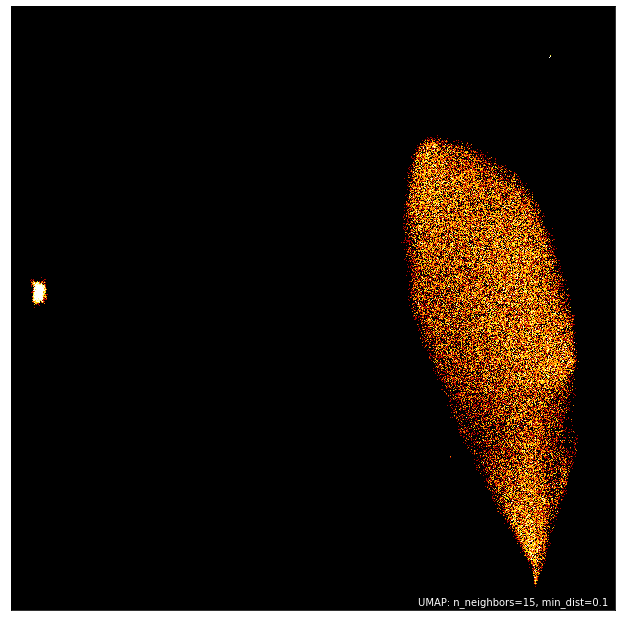

In [50]:
umap.plot.points(mapper_users, theme='fire')
plt.savefig("figures/uesrs.png")